In [91]:
import pandas as pd 
import numpy as np
import os
import sys
import seaborn as sns
import akshare as ak
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

DEFAULT_TODAY = (datetime.today() - timedelta(days=365)).strftime('%Y%m%d')
DEFAULT_LASTYEAR = datetime.today().strftime('%Y%m%d')

os.chdir(sys.path[0] + "\\..")
os.getcwd()

'd:\\Documents\\PycharmProject\\eastmoney_data'

In [139]:
RATING_WINDOW = 30

PREDICT_WINDOW = 7
prev_d = 5 * PREDICT_WINDOW // 7


In [151]:
rating_date_list = [(datetime.today() - timedelta(days=PREDICT_WINDOW) - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(RATING_WINDOW)]
print(rating_date_list[0],rating_date_list[-1])

rating_df = pd.read_csv("个股研报.csv")
rating_df['publishDate'] = pd.to_datetime(rating_df['publishDate']).dt.strftime('%Y-%m-%d')
rating_df = rating_df[rating_df['publishDate'].isin(rating_date_list)]
rating_df['publishDate'] = pd.to_datetime(rating_df['publishDate'])
rating_df['publishDate'] = rating_df["publishDate"].max() - pd.to_datetime(rating_df['publishDate'])
rating_df['publishDate'] = rating_df['publishDate'].astype('timedelta64[D]').astype(int)
rating_df["emRatingValue"] = rating_df["emRatingValue"] * np.exp(np.linspace(-5, 0, RATING_WINDOW))[-(rating_df['publishDate']+1)]
rating_df = rating_df[rating_df["emRatingValue"].notnull()].groupby(["stockCode","stockName"]).agg(
    orgCount=("stockCode", "count"),
    orgSList=("orgSName", set),
    emRatingValue=("emRatingValue", "mean")
).reset_index()
rating_df['stockCode'] = rating_df['stockCode'].astype("str").apply(lambda x: x.zfill(6)).to_list()
rating_df

2023-06-24 2023-05-26


In [142]:
dirPath = "data/raw/"
tagDirPath = dirPath + "sohu_stock/"
data_date_lst = [] 
for filename in os.listdir(tagDirPath):
    if os.path.isdir(tagDirPath + filename):
        data_date_lst.append(datetime.strptime(filename, '%Y-%m-%d').date())

date = max(data_date_lst).strftime('%Y-%m-%d')
tag_df = pd.read_csv(tagDirPath + date + ".csv")

tag_df["stockCode"] = tag_df['stockCode'].astype("str").apply(lambda x: x.zfill(6)).to_list()
tag_df[~tag_df['sector'].isin(["央视50_","AH股","分拆预期","破净股","证金持股","上证50_","HS300_","上证180_","中证500","深成500","深证100R","标准普尔"])]
tag_df

,stockCode,stockName,sector,sectorCount,date
0,600337,美克家居,2025规划,82,2023-06-24
1,300720,海川智能,2025规划,82,2023-06-24
2,000810,创维数字,2025规划,82,2023-06-24
3,603111,康尼机电,2025规划,82,2023-06-24
4,300729,乐歌股份,2025规划,82,2023-06-24
...,...,...,...,...,...
62769,600666,ST瑞德,黑龙江板块,40,2023-06-24
62770,300900,广联航空,黑龙江板块,40,2023-06-24
62771,600853,龙建股份,黑龙江板块,40,2023-06-24
62772,688459,哈铁科技,黑龙江板块,40,2023-06-24


In [143]:
loading = True
stock_code_list = rating_df['stockCode'].to_list()

if loading:
    priceDirPath = dirPath + "price/"
    
    # Get the newest date of folders
    for filename in os.listdir(priceDirPath):
        data_date_lst.append(datetime.strptime(filename, '%Y-%m-%d').date())
    date = max(data_date_lst).strftime('%Y-%m-%d')    
    priceDirPath = dirPath + "price/" + date + "/"
    print(priceDirPath)

    # Loading price df
    price_df_list = []
    for stockCode_filename in os.listdir(priceDirPath):
        if stockCode_filename.split('.')[0] in stock_code_list:
            stock_price_df = pd.read_csv(priceDirPath + stockCode_filename, index_col=0)
            price_df_list.append(stock_price_df)
    price_df = pd.concat(price_df_list)

    price_df['日期'] = pd.to_datetime(price_df['日期'])
    price_df = price_df[price_df['日期']>(price_df['日期'].max()-pd.Timedelta(days=365))]
    price_df["stockCode"] = price_df['stockCode'].astype("str").apply(lambda x: x.zfill(6)).to_list()

    price_df = pd.merge(tag_df, price_df, how='outer',on='stockCode')

price_df = price_df[price_df['stockCode'].isin(rating_df['stockCode'])]

data/raw/price/2023-06-30/


In [144]:
# ---- inner function ----
def maxProfit(prices: list) -> int:
    pnl = 0
    min_price = prices[0]

    for i in range(1, len(prices)):
        if prices[i] < prices[i - 1]:
            min_price = min(min_price, prices[i])

        pnl = max(pnl, prices[i] - min_price)
    return pnl

DEFAULT_LASTWEKK=5
DEFAULT_LAST2WEKK=10

def stockPlot(data,predict_date:str=datetime.today().strftime('%Y-%m-%d'), save=False):
    from matplotlib import font_manager
    fontP = font_manager.FontProperties()
    fontP.set_family('SimHei')
    fontP.set_size(20)

    # 创建包含两个子图的图表对象
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 设置x轴刻度间隔为每隔n个数据点显示一个刻度
    n = int(len(data.index)/12)
    plt.xticks(range(0, len(data.index), n), data.index[::n], rotation=45)

    # 绘制价格曲线
    ax1.plot(data['收盘'], label='Close')
    ax1.plot(data['开盘'], label='Open', color='red', linestyle='--')
    ax1.axvline(x=predict_date, color="blue", linestyle="--")

    # 设置子图1的标题和标签
    ax1.set_title("/".join(data["sector"].drop_duplicates().to_list()),fontproperties=fontP)
    ax1.set_ylabel('Price')

    # 添加图例到子图1
    ax1.legend()

    # 绘制成交量曲线
    ax2.bar(data.index, data['成交额'], label='Volume')
    ax2.axvline(x=predict_date, color="blue", linestyle="--")

    # 设置子图2的标题和标签
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Time')

    # 添加图例到子图2
    ax2.legend()

    # 调整子图之间的间距
    plt.tight_layout()

    # 保存
    if save:
        print("saving", "_".join(data["sector"].drop_duplicates().to_list()))
        dir_path = "figs/"
        today = datetime.today().strftime('%Y-%m-%d')
        if not os.path.exists(dir_path + today):
            os.makedirs(dir_path + today)
        plt.savefig(dir_path + today + "/%s.png" % "_".join(data["sector"].drop_duplicates().to_list()))

    # 显示图表
    plt.show()

def getIndexData(stock_code_lst, start_date=DEFAULT_TODAY, end_date=DEFAULT_LASTYEAR):
    price_data_list = []
    df_row_lst = []

    for stock_code in stock_code_lst:
        data = ak.stock_zh_a_hist(symbol=str(stock_code), period="daily", start_date=start_date, end_date=end_date, adjust="qfq")
        data["stockCode"] = str(stock_code)

        # data = pd.merge(data, stock_info_df, how="left", on="stockCode")
        # data["总流通金额"] = data["开盘"]*data['A股流通股本']
        row = {
            "stockCode": stock_code,
            "PnL7": maxProfit(data['开盘'][-5:].to_list()),
            "PnL30": maxProfit(data['开盘'][-22:].to_list()),
            "PnL90": maxProfit(data['开盘'][-66:].to_list()),
        }
        df_row_lst.append(row)
        price_data_list.append(data)

    analytics_df = pd.DataFrame(df_row_lst)
    price_hist_df = pd.concat(price_data_list)
    data_df = pd.merge(price_hist_df,analytics_df,how="left", on="stockCode")
    data_df = data_df.groupby('日期').agg({
        '收盘': lambda x: (x * data_df.loc[x.index, '开盘']).sum() / data_df.loc[x.index, '开盘'].sum(),
        '开盘': lambda x: (x * data_df.loc[x.index, '开盘']).sum() / data_df.loc[x.index, '开盘'].sum(),
        '成交额' : lambda x: sum(x),
                                })

    return data_df, price_hist_df

In [111]:
sector_list = price_df['sector'].drop_duplicates().to_list()

sector_list = [
    "AIGC",
    "算力概念",
    "光伏",
    "半导体"
]

sector_list = [
    "HIT电池",
    "TOPCon电池",
    "核电"
]

sector_list = [
    "互联医疗",
    "创新药",
    "核电",
    "节能环保",
    "降解塑料"
]

# sector_list = df['sector'].to_list()

data_list = []
for sector in sector_list:
    print(sector)
    data = price_df[price_df['sector'].str.contains(sector)]
    print(data['sector'].drop_duplicates().to_list())
    data = data.drop(columns=["sector","sectorCount"])
    print(len(data))
    data = data.drop_duplicates()
    print(len(data))

    data = data.groupby('日期').agg({
            '收盘': lambda x: x.mean(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '开盘': lambda x: x.mean(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '成交额': lambda x: sum(x),
                                    })
    # data.reset_index()
    data['sector'] = sector
    data.index = data.index.astype(str)

    data_list.append(data)

互联医疗
['互联医疗']
3645
3645
创新药
['创新药']
1944
1944
核电
['核能核电']
3159
3159
节能环保
['节能环保']
6970
6970
降解塑料
['降解塑料']
1944
1944


start date: 2023-06-26
saving 互联医疗


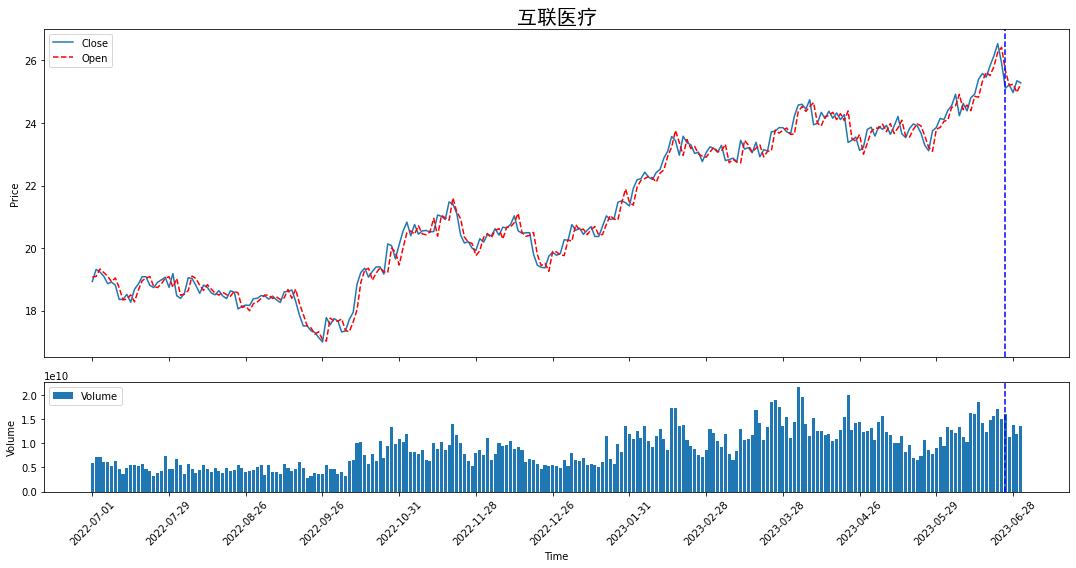

saving 创新药


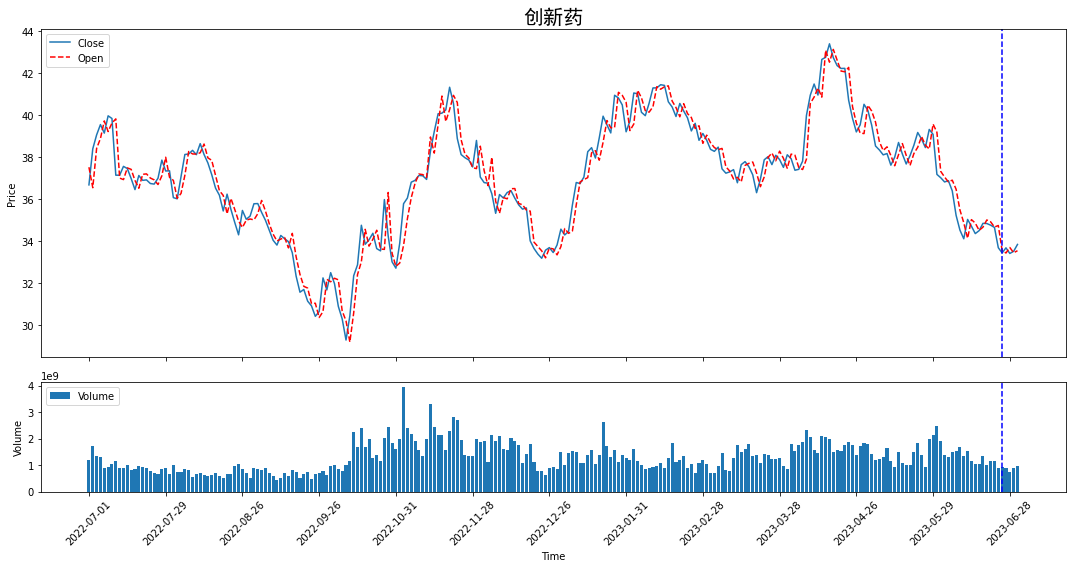

saving 核电


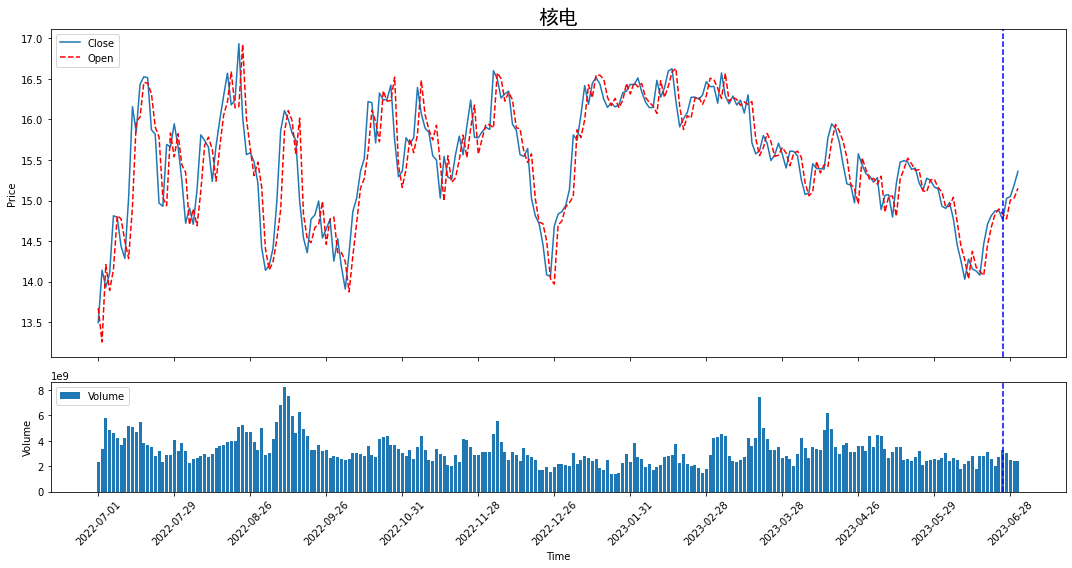

saving 节能环保


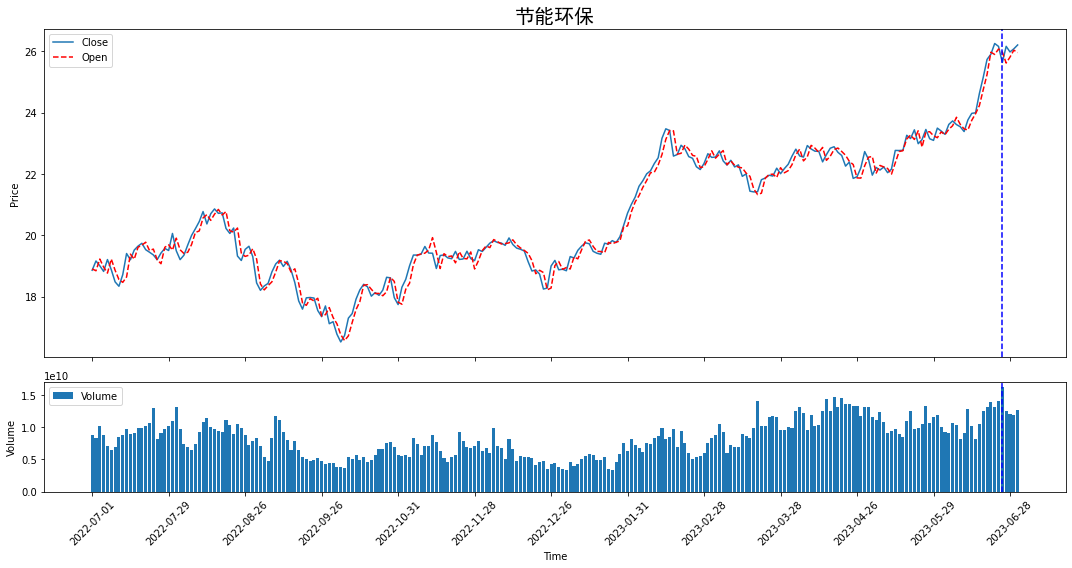

saving 降解塑料


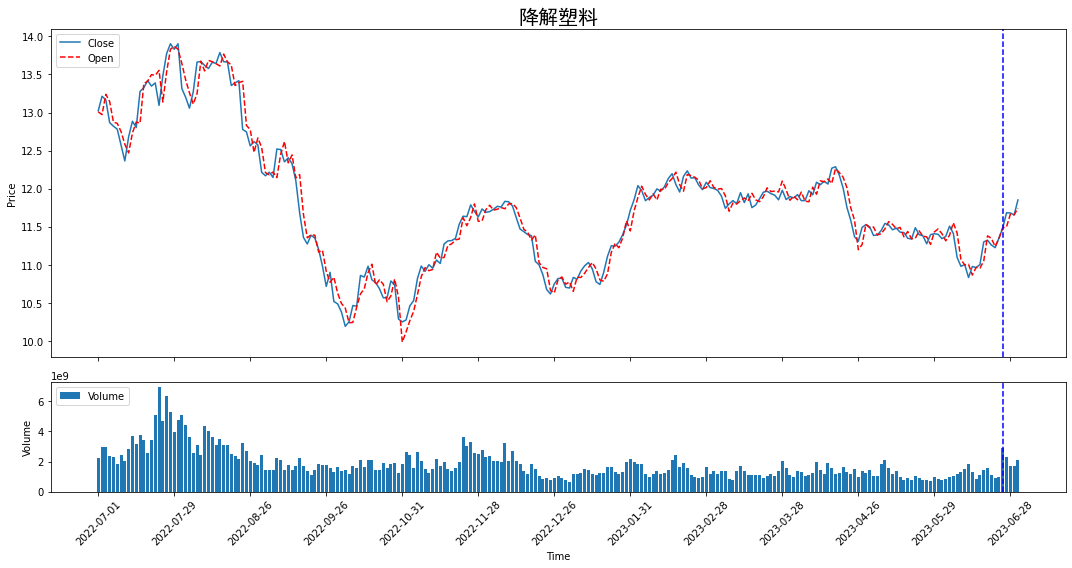

In [99]:

date_list = [(datetime.today() - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(PREDICT_WINDOW)]
predict_date = data.loc[data.index.isin(date_list)].index[0]
last_date = data.loc[data.index.isin(date_list)].index[-1]

print("start date:", predict_date)
print("last date:", predict_date)

for data in data_list:
    stockPlot(data,predict_date=predict_date,save=True)

互联医疗
['互联医疗']
15
15
创新药
['创新药']
8
8
核电
['核能核电']
13
13
节能环保
['节能环保']
29
29
降解塑料
['降解塑料']
8
8
start date: 2023-06-26
saving 互联医疗


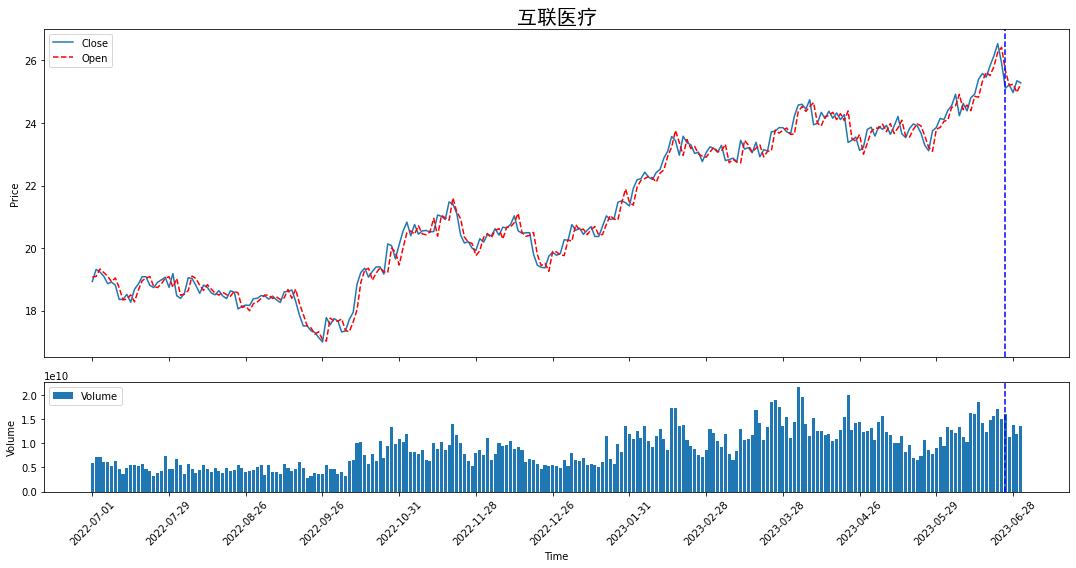

saving 创新药


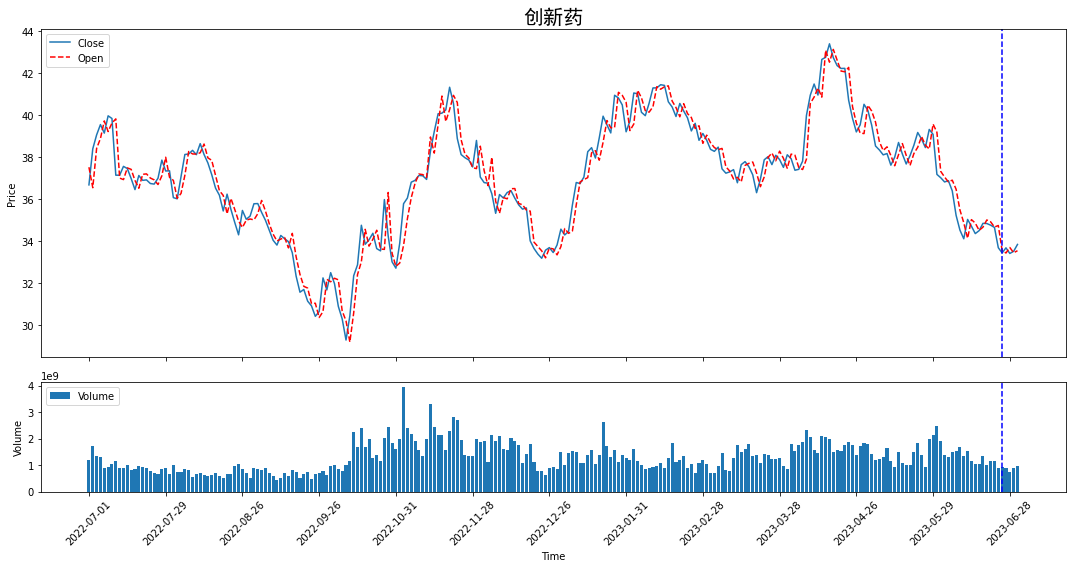

saving 核电


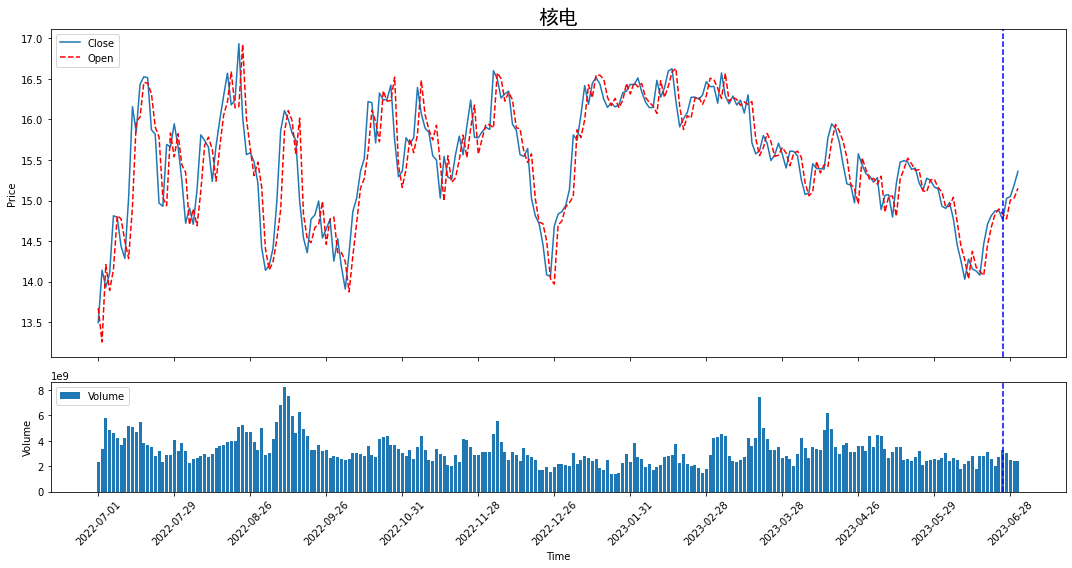

saving 节能环保


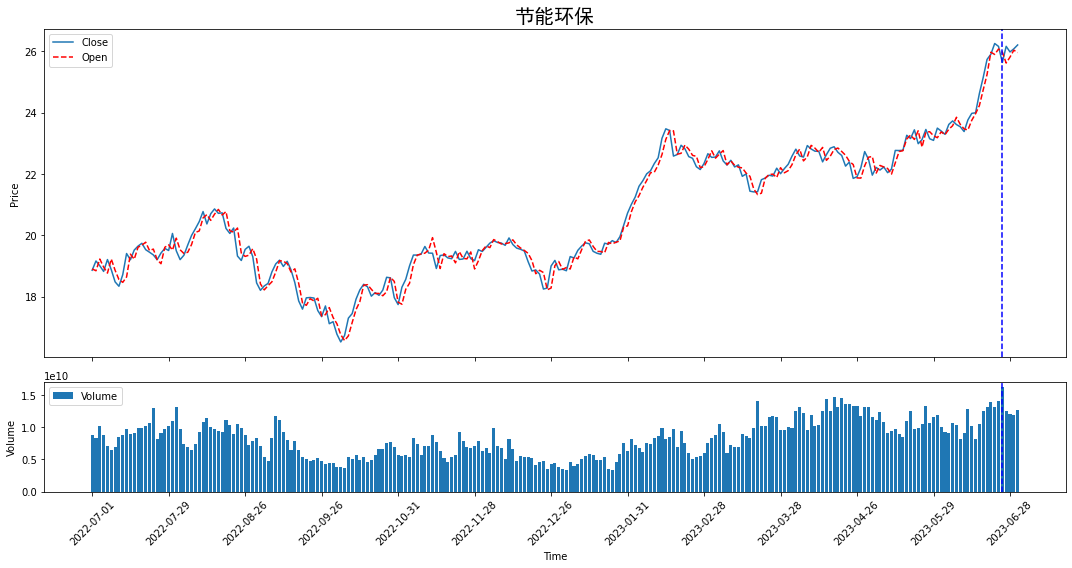

saving 降解塑料


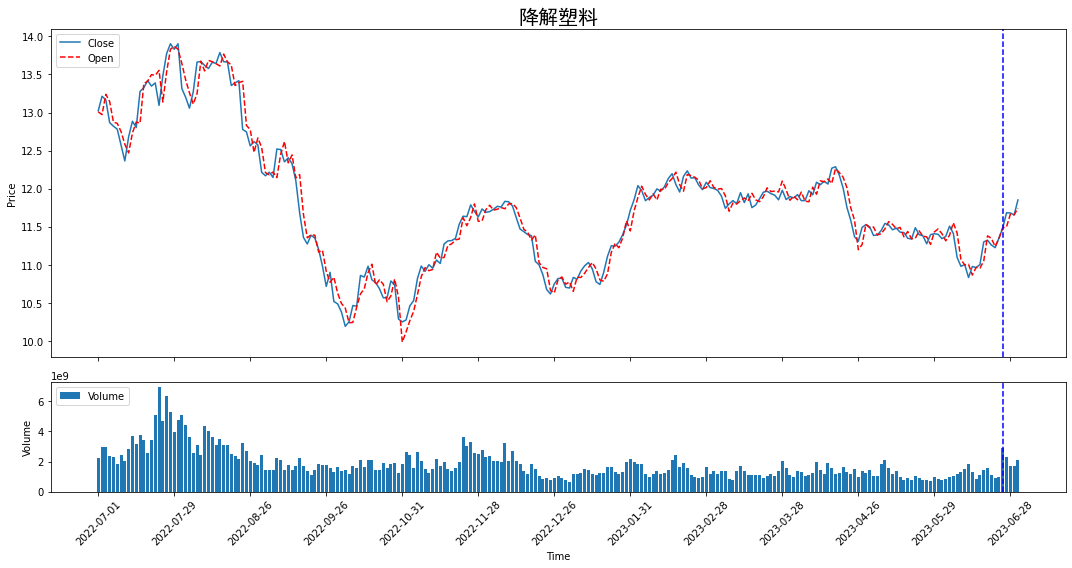

In [155]:
data_list = []
for sector in sector_list:
    print(sector)
    stock_codes=rating_df['stockCode'].drop_duplicates() 
    data = price_df[(price_df['sector'].str.contains(sector)) & (price_df['stockCode'].isin(stock_codes))]
    print(data['sector'].drop_duplicates().to_list())
    data = data.drop(columns=["sector","sectorCount"])
    print(len(data[['stockCode','stockName']].drop_duplicates()))
    data = data.drop_duplicates()
    print(len(data[['stockCode','stockName']].drop_duplicates()))

    data = data.groupby('日期').agg({
            '收盘': lambda x: x.mean(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '开盘': lambda x: x.mean(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '成交额': lambda x: sum(x),
                                    })
    # data.reset_index()
    data['sector'] = sector
    data.index = data.index.astype(str)

    data_list.append(data)


date_list = [(datetime.today() - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(PREDICT_WINDOW)]
predict_date = data.loc[data.index.isin(date_list)].index[0]

print("start date:", predict_date)

for data in data_list:
    stockPlot(data,predict_date=predict_date,save=True)

In [156]:
price_df[(price_df['sector'].str.contains('降解塑料'))][['stockCode','stockName']].drop_duplicates()

,stockCode,stockName
740108,002340,格林美
799002,002064,华峰化学
976993,600346,恒力石化
1087795,002585,双星新材
1442452,600710,苏美达
1788779,002019,亿帆医药
2110435,600433,冠豪高新
2161657,002986,宇新股份


In [157]:
price_df[(price_df['stockCode'].str.contains("002019"))][['stockCode','stockName','sector']].drop_duplicates()

,stockCode,stockName,sector
1784648,002019,亿帆医药,中药概念
1784891,002019,亿帆医药,中证500
1785134,002019,亿帆医药,免疫治疗
1785377,002019,亿帆医药,创新药
1785620,002019,亿帆医药,医药生物
1785863,002019,亿帆医药,太阳能
1786106,002019,亿帆医药,富时罗素
1786349,002019,亿帆医药,新材料
1786592,002019,亿帆医药,标准普尔
1786835,002019,亿帆医药,浙江板块


In [165]:
data_list = []
for sector in sector_list:
    print(sector)
    stock_codes=rating_df['stockCode'].drop_duplicates() 
    data = price_df[(price_df['sector'].str.contains(sector)) & (price_df['stockCode'].isin(stock_codes))]
    print(data['sector'].drop_duplicates().to_list())
    data = data.drop(columns=["sector","sectorCount"])
    print(len(data[['stockCode','stockName']].drop_duplicates()))
    data = data.drop_duplicates()
    print(len(data[['stockCode','stockName']].drop_duplicates()))

    data = data.groupby('日期').agg({
            '收盘': lambda x: x.sum(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '开盘': lambda x: x.sum(),  # (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
            '成交额': lambda x: sum(x),
                                    })
    # data.reset_index()
    data['sector'] = sector
    data.index = data.index.astype(str)

    data_list.append(data)


date_list = [(datetime.today() - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(PREDICT_WINDOW)]
predict_date = data.loc[data.index.isin(date_list)].index[0]

print("start date:", predict_date)

互联医疗
['互联医疗']
15
15
创新药
['创新药']
8
8
核电
['核能核电']
13
13
节能环保
['节能环保']
29
29
降解塑料
['降解塑料']
8
8
start date: 2023-06-26


In [168]:
last_date = data.loc[data.index.isin(date_list)].index[-1]

In [185]:
invested =  pd.concat([data[data.index==predict_date] for data in data_list])['开盘'].sum()*100
returned =  pd.concat([data[data.index==last_date] for data in data_list])['收盘'].sum()*100
PnL = returned - invested
print("{:.2f}".format(PnL),"{:.2f}".format(invested),"{:.2f}".format(returned),"{:.2%}".format(PnL/invested))

1309.00 169132.00 170441.00 0.77%


In [159]:
for data in data_list:
    data = data.loc[data.index.isin(date_list)]
    print("/".join(data["sector"].drop_duplicates().to_list()), 
          "{:.2%}".format((data['收盘'][-1] - data['收盘'][0])/data['收盘'][0]),
          "{:.2%}".format(maxProfit(data['收盘'])/data['收盘'][0])
          )


互联医疗 0.68% 1.49%
创新药 1.21% 1.29%
核电 4.06% 4.06%
节能环保 2.23% 2.23%
降解塑料 3.21% 3.21%


In [160]:
price_sub_df = price_df[price_df['日期'] > (price_df["日期"].max() - pd.Timedelta(days=PREDICT_WINDOW))]

score_list = []
for sector in price_sub_df['sector'].drop_duplicates().to_list():
    data = price_sub_df[price_sub_df['sector']==sector]
    data = data.groupby('日期').agg({
        '收盘': lambda x: (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
        '开盘': lambda x: (x * data.loc[x.index, '开盘']).sum() / data.loc[x.index, '开盘'].sum(),
        '成交额': lambda x: sum(x),
        'sector': lambda x: list(x)[0],
                                })
    data = data.sort_values('日期')
    
    data = data.loc[data.index.isin(date_list)]
    score = {
        "sector": "/".join(data["sector"].drop_duplicates().to_list()), 
        "closePnL": (data['收盘'][-1] - data['收盘'][0])/data['收盘'][0],
        "maxPnL":maxProfit(data['收盘'])/data['收盘'][0],
    }
    score_list.append(score) 

score_df = pd.DataFrame(score_list) 

# Index I select
score_data_list = []
for data in data_list:
    data = data.loc[data.index.isin(date_list)]
    score = {
        "sector": "/".join(data["sector"].drop_duplicates().to_list()), 
        "closePnL": (data['收盘'][-1] - data['收盘'][0])/data['收盘'][0],
        "maxPnL":maxProfit(data['收盘'])/data['收盘'][0],
    }
    score_data_list.append(score)
    print(score)
score_data_df = pd.DataFrame(score_data_list)  
score_data_df[['closePnL','maxPnL']] = score_data_df[['closePnL','maxPnL']].applymap(lambda x: "{:.2%}".format(x))
score_data_df

{'sector': '互联医疗', 'closePnL': 0.006822767335669952, 'maxPnL': 0.014893278114049158}
{'sector': '创新药', 'closePnL': 0.012112602340274437, 'maxPnL': 0.01286029384276068}
{'sector': '核电', 'closePnL': 0.04064828808171346, 'maxPnL': 0.04064828808171346}
{'sector': '节能环保', 'closePnL': 0.022276928043908392, 'maxPnL': 0.022276928043908392}
{'sector': '降解塑料', 'closePnL': 0.03211408665360334, 'maxPnL': 0.03211408665360334}


,sector,closePnL,maxPnL
0,互联医疗,0.68%,1.49%
1,创新药,1.21%,1.29%
2,核电,4.06%,4.06%
3,节能环保,2.23%,2.23%
4,降解塑料,3.21%,3.21%


In [161]:
from matplotlib import font_manager
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(12)


5 5


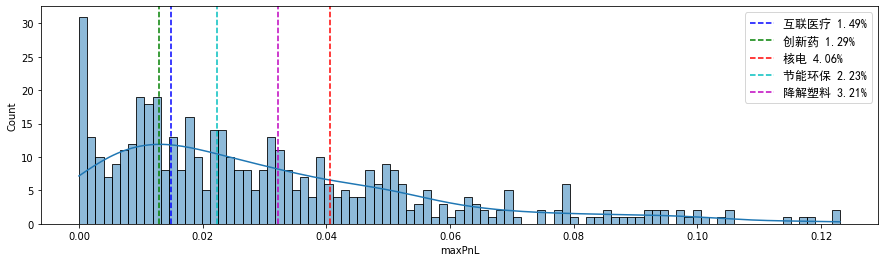

In [162]:
plt.figure(figsize=(15,4))
dist = sns.histplot(score_df['maxPnL'],bins=int(len(score_df['sector'].drop_duplicates())/5),kde=True)
# plt.vlines(x=[0,0.1,0.2],ymin=0,ymax=dist.get_ylim(),colors='red')
colors = 'blue,green,red,c,m,y,k'.split(',') * 10

n=0
for i,score in enumerate(score_data_list):
    # if score['maxPnL'] > score_df['maxPnL'].mean():
        n += 1
        plt.axvline(x=score['maxPnL'],linestyle="--", color=colors[i],
                    label=score["sector"] + " " + "{:.2%}".format(score['maxPnL']))

plt.legend(prop=fontP)

print(n,len(score_data_list))

In [163]:
score_df

,sector,closePnL,maxPnL
0,2025规划,-0.017786,0.000000
1,AIGC概念,-0.090237,0.000000
2,F5G概念,-0.007316,0.049881
3,MiniLED,0.031855,0.043587
4,MSCI中国,0.009460,0.009671
...,...,...,...
463,壳资源,0.099687,0.099687
464,生物质能发电,0.039801,0.039801
465,转基因,0.019778,0.019778
466,地塞米松,0.005932,0.032627


5 5


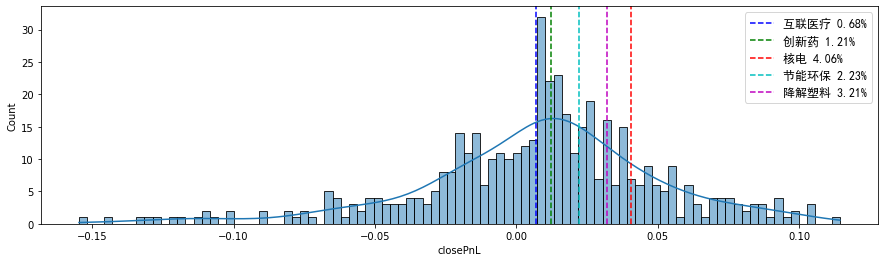

In [164]:
plt.figure(figsize=(15,4))
dist = sns.histplot(score_df['closePnL'],bins=int(len(score_df['sector'].drop_duplicates())/5),kde=True)
# plt.vlines(x=[0,0.1,0.2],ymin=0,ymax=dist.get_ylim(),colors='red')
colors = 'blue,green,red,c,m,y,k'.split(',') * 10

n=0
for i,score in enumerate(score_data_list):
    # if score['closePnL'] > score_df['closePnL'].mean():
        n += 1
        plt.axvline(x=score['closePnL'],linestyle="--", color=colors[i],
                    label=score["sector"] + " " + "{:.2%}".format(score['closePnL']))
plt.legend(prop=fontP)
print(n,len(score_data_list))


In [24]:
len(score_df[score_df['closePnL']>score_df['closePnL'].mean()]), len(score_df), len(score_df[score_df['closePnL']>score_df['closePnL'].mean()])/len(score_df)

(255, 468, 0.5448717948717948)

In [222]:
len(score_df)

468

In [58]:
score_df[(score_df['closePnL']>0.06) & (score_df['closePnL']<0.1)]

,sector,closePnL,maxPnL
3,MiniLED,0.062201,0.085130
18,智能家居,0.061653,0.088581
30,车联网,0.095289,0.116938
33,中证500,0.075234,0.128078
40,央企改革,0.084764,0.116712
45,风能,0.078955,0.094812
47,一带一路,0.081562,0.112900
56,换电概念,0.098613,0.117602
57,新能源车,0.093641,0.105233
58,无人驾驶,0.087752,0.114631


In [59]:

df = price_sub_df.groupby("stockCode").agg(
    open=pd.NamedAgg(column="开盘", aggfunc=lambda x: list(x)[-1]),
    prevOpen=pd.NamedAgg(column="开盘", aggfunc=lambda x: list(x)[0]),
    close=pd.NamedAgg(column="收盘", aggfunc=lambda x: list(x)[-1]),
    prevClose=pd.NamedAgg(column="收盘", aggfunc=lambda x: list(x)[0]),
)
df = pd.merge(tag_df,df,on='stockCode',how="left")
df[df['stockCode']=='000002']

,stockCode,stockName,sector,sectorCount,date,open,prevOpen,close,prevClose
661,000002,万科Ａ,AH股,148,2023-06-24,13.94,14.57,13.94,14.89
1528,000002,万科Ａ,HS300_,300,2023-06-24,13.94,14.57,13.94,14.89
2475,000002,万科Ａ,MSCI中国,665,2023-06-24,13.94,14.57,13.94,14.89
3320,000002,万科Ａ,REITs概念,26,2023-06-24,13.94,14.57,13.94,14.89
10365,000002,万科Ａ,养老概念,109,2023-06-24,13.94,14.57,13.94,14.89
14350,000002,万科Ａ,北京冬奥,78,2023-06-24,13.94,14.57,13.94,14.89
22967,000002,万科Ａ,央视50_,50,2023-06-24,13.94,14.57,13.94,14.89
24869,000002,万科Ａ,富时罗素,1313,2023-06-24,13.94,14.57,13.94,14.89
27204,000002,万科Ａ,房地产,123,2023-06-24,13.94,14.57,13.94,14.89
30424,000002,万科Ａ,智能家居,144,2023-06-24,13.94,14.57,13.94,14.89
